## Part 2: Spatial Operations in PostGIS.
<details>
  <summary>Click to view!</summary>
   
***
   
#### Using a PostGIS database allows for spatial transformations and joins to be conducted quickly in one environment. 
NOTE: for all tables created, outside refinement/reprojecting/ and inedexes were created in SQL code on PostGIS

![Project Diagram](images/Project_Diagram.png)



In [2]:
import pandas as pd
import geopandas as gpd
import sqlalchemy as sql
import psycopg2 as psy
import numpy as np
import matplotlib as plt
from shapely import wkt


%matplotlib inline

In [3]:
from sqlalchemy import create_engine

# Postgres uname, pw and database name
POST_address = 'localhost'
POST_port = '5432'
POST_user = 'postgres'
POST_pw = 'pw'
POST_dbname = 'postgres'

# Long string that contains Postgres login information
POST_connection = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
               .format(username = POST_user,
                       password = POST_pw,
                       ipaddress = POST_address,
                       port = POST_port,
                       dbname = POST_dbname)
               )
# Creating connection
conx = create_engine(POST_connection)

In [62]:
# connection has read through without any errors - let's confirm this works
pd.read_sql_query('''SELECT * FROM public.collisions LIMIT 5;''', conx)

,index,crash_date,crash_time,borough,latitude,longitude,location,on_street_name,cross_street_name,off_street_name,...,unique_id,crash_date.1,crash_time.1,person_type,person_injury,vehicle_id,person_age,ped_location,count_col,geom
0,259932,03/15/2019,12:10,STATEN ISLAND,40.560474,-74.16689,POINT (-74.16689 40.560474),ARTHUR KILL ROAD,GETZ AVENUE,None,...,9131774.0,03/15/2019,12:10,Occupant,Unspecified,18587776.0,30.0,None,4,010100002026690000E4016553AE8A52C01021AE9CBD47...
1,259933,03/14/2019,9:55,BRONX,40.820305,-73.89083,POINT (-73.89082999999999 40.820305),BRUCKNER BOULEVARD,HUNTS POINT AVENUE,None,...,9032889.0,03/14/2019,9:55,Occupant,Unspecified,18538752.0,0.0,None,4,010100002026690000EE12D55B037952C065DF15C1FF68...
2,259934,03/14/2019,14:30,BRONX,40.863007,-73.89418,POINT (-73.89418000000001 40.863007),EAST KINGSBRIDGE ROAD,BRIGGS AVENUE,None,...,9102096.0,03/14/2019,14:30,Occupant,Unspecified,18573086.0,40.0,None,6,010100002026690000302FC03E3A7952C00B9C6C03776E...
3,259935,03/14/2019,10:44,QUEENS,40.734188,-73.87400,POINT (-73.874 40.734188),HOFFMAN DRIVE,57 AVENUE,None,...,9122157.0,03/14/2019,10:44,Occupant,Unspecified,18583062.0,29.0,None,4,0101000020266900000E2DB29DEF7752C0CE8E54DFF95D...
4,259936,03/16/2019,15:30,None,40.744465,-73.77179,POINT (-73.77179 40.744465),CLEARVIEW EXPRESSWAY,None,None,...,9144804.0,03/16/2019,15:30,Occupant,Unspecified,18594176.0,0.0,None,5,0101000020266900004F58E201657152C023020EA14A5F...


![Intersection example](images\intersection.png)

With the CSCL data, we will find all intersection location(i.e. places where different centerlines meet. The image above illustrates what this query below essentially accomplishes

In [ ]:
pd.read_sql_query('''
                            CREATE TABLE intrsct_pts AS
                            (SELECT 
                                ST_Intersection(a.geom, b.geom) as geom,
                                COUNT (Distinct a.gid)
                            FROM
                                public.cscl_prj AS a,
                                public.cscl_prj AS b
                            WHERE
                                ST_Touches(a.geom, b.geom)
                            GROUP BY
                                ST_Intersection(a.geom, b.geom)
                            );
                                ''', conx)
# result: 59, 144 point intersections.

In [7]:
df1 = pd.read_sql_query(''' SELECT * FROM public.intrsct_pts''',conx) # read in this data to view
df1.head()

,geom,count
0,0101000020D70800000300382F7FF62B4106F0BFF7FF93...,3
1,0101000020D7080000FFFFC79869F82B4190EFBFCA2998...,3
2,0101000020D7080000060070E34AFA2B41A1F03FC41B9C...,3
3,0101000020D7080000FAFF3F973CFC2B41C6F1FF68EA9F...,4
4,0101000020D7080000FFFF479434FE2B4130F03F8C00A4...,4


In [8]:

gdf1 = gpd.read_postgis(''' SELECT * FROM public.intrsct_pts''', con = conx)
aadt = gpd.read_postgis(''' SELECT * FROM public.aadt_proj''', con = conx)
# colls = gpd.read_postgis(''' SELECT * FROM public.collisions_prj''', con = conx)
vzv = gpd.read_postgis(''' SELECT * FROM public.vzv_lp_proj''', con = conx)
aadt.head()

,gid,objectid,rc_id,loc_error,tdv_route,cc_id,roadwaytyp,begindesc,enddesc,muni,...,aadt_type,aadt_year,vol_txt,class_txt,speed_txt,data_type,vol_tdv,class_tdv,speed_tdv,geom
0,6,7980,05_3239,NO ERROR,I678 Exit 12A,None,Ramp,DIVERGE FROM MEADOW LAKE RD,I678 NB (ON),CITY OF NEW YORK,...,FORECAST,2015.0,Open Report - 2011,Open Report - No Class,Open Report - No Speed,VOLUME,/YR2011/R11/05_Queens/05_3239.pdf,/YR2015/noclass.pdf,/YR2015/noSpeed.pdf,(LINESTRING (1029691.720785881 208044.87173641...
1,23,1909,02_3051,NO ERROR,907C Exit 6 CRO,None,Ramp,907C SW (OFF),DIVERGE TO AVE Z,CITY OF NEW YORK,...,FORECAST,2015.0,Open Report - 2011,Open Report - No Class,Open Report - No Speed,VOLUME,/YR2011/R11/02_Kings/02_3051.pdf,/YR2015/noclass.pdf,/YR2015/noSpeed.pdf,(LINESTRING (988900.0439571568 151849.21676387...
2,28,7884,05_1245,NO ERROR,LITTLE NECK PKY,None,Road,JAMAICA AVE,HILLSIDE AVE,CITY OF NEW YORK,...,FORECAST,2015.0,Open Report - 2013,Open Report - 2010,Open Report - No Speed,"VOLUME, CLASS",/YR2013/R11/05_Queens/05_1245_VOL_11-2013.pdf,/YR2010/Other/Class/R11/05_Queens/05_1245_Clas...,/YR2015/noSpeed.pdf,(LINESTRING (1064495.900844174 204377.59812412...
3,36,845,01_4270,NO ERROR,VN CRTLNDT AV E,None,Road,JEROME AVE,GRAND CONCOURSE,CITY OF NEW YORK,...,FORECAST,2015.0,Open Report - 2010,Open Report - No Class,Open Report - No Speed,VOLUME,/YR2010/R11/01_Bronx/01_4270.pdf,/YR2015/noclass.pdf,/YR2015/noSpeed.pdf,(LINESTRING (1015309.813558938 258824.47103439...
4,49,653,01_4155,NO ERROR,HOLLYWOOD AVE,None,Road,HARDING AVE,LAWTON AVE,CITY OF NEW YORK,...,NO DATA,2015.0,Open Report - No Data,Open Report - No Class,Open Report - No Speed,NO DATA,/YR2015/nodata.pdf,/YR2015/noclass.pdf,/YR2015/noSpeed.pdf,(LINESTRING (1035719.55331232 236742.145335828...


Plot our data, ensure that projection 2263 can be plotted


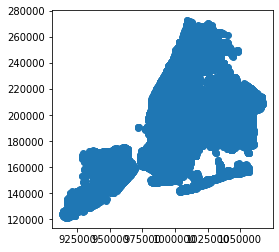

In [66]:
# intersection points
gdf1 = gdf1.to_crs(epsg=2263)
ax = gdf1.plot()

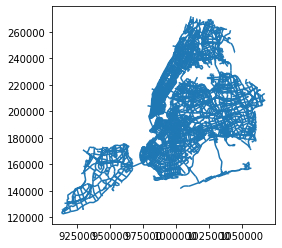

In [34]:
# street traffic totals
aadt_1 = aadt.to_crs(epsg=2263)
ax = aadt_1.plot()

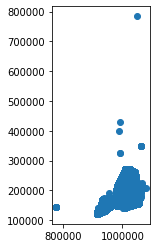

In [65]:
# collision data points
colls_1 = colls.to_crs(epsg=2263)
ax = colls_1.plot()

Collisions data was cleaned, still a few points outside of NYC, as is seen by the plot above. This will not matter for calculations, as only points within intersection 'buffer zones' will be included in calculation.


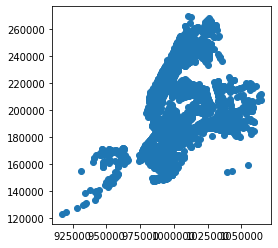

In [16]:
# VZV street light points
vzv_1 = vzv.to_crs(epsg=2263)
ax = vzv_1.plot()

Creating a 30-ft buffer around each intersection in an attempt to capture all points within the intersection area

In [ ]:

pd.read_sql_query('''
                    CREATE TABLE intrsct_buff AS ( 
                    SELECT ST_Transform(
                    ST_Buffer(
                        ST_Transform(pt.geom,4326)::geography,
                    30.0)::geometry,
                    2263) as geom, pt.count
                    FROM public.intrsct_pts as pt
                    );
                                ''', conx)
#change to 4326 and cast to geography(pt.geom, 4326)::geography, buffer 30ft, then as geom sets back to CRS


In [68]:
gd_buff = gpd.read_postgis(''' SELECT * FROM public.intrsct_buff''', con = conx)
gd_buff.head()

,geom,count
0,"POLYGON ((916386.0466261646 121150.880001415, ...",3
1,"POLYGON ((916631.2527894553 121217.4940189881,...",3
2,"POLYGON ((916871.8985892923 121280.6174359997,...",3
3,"POLYGON ((917120.749772086 121341.5326624326, ...",4
4,"POLYGON ((917372.7439599608 121406.9162725191,...",4


WKT in the geometry seems to be correct format -- let's plot!

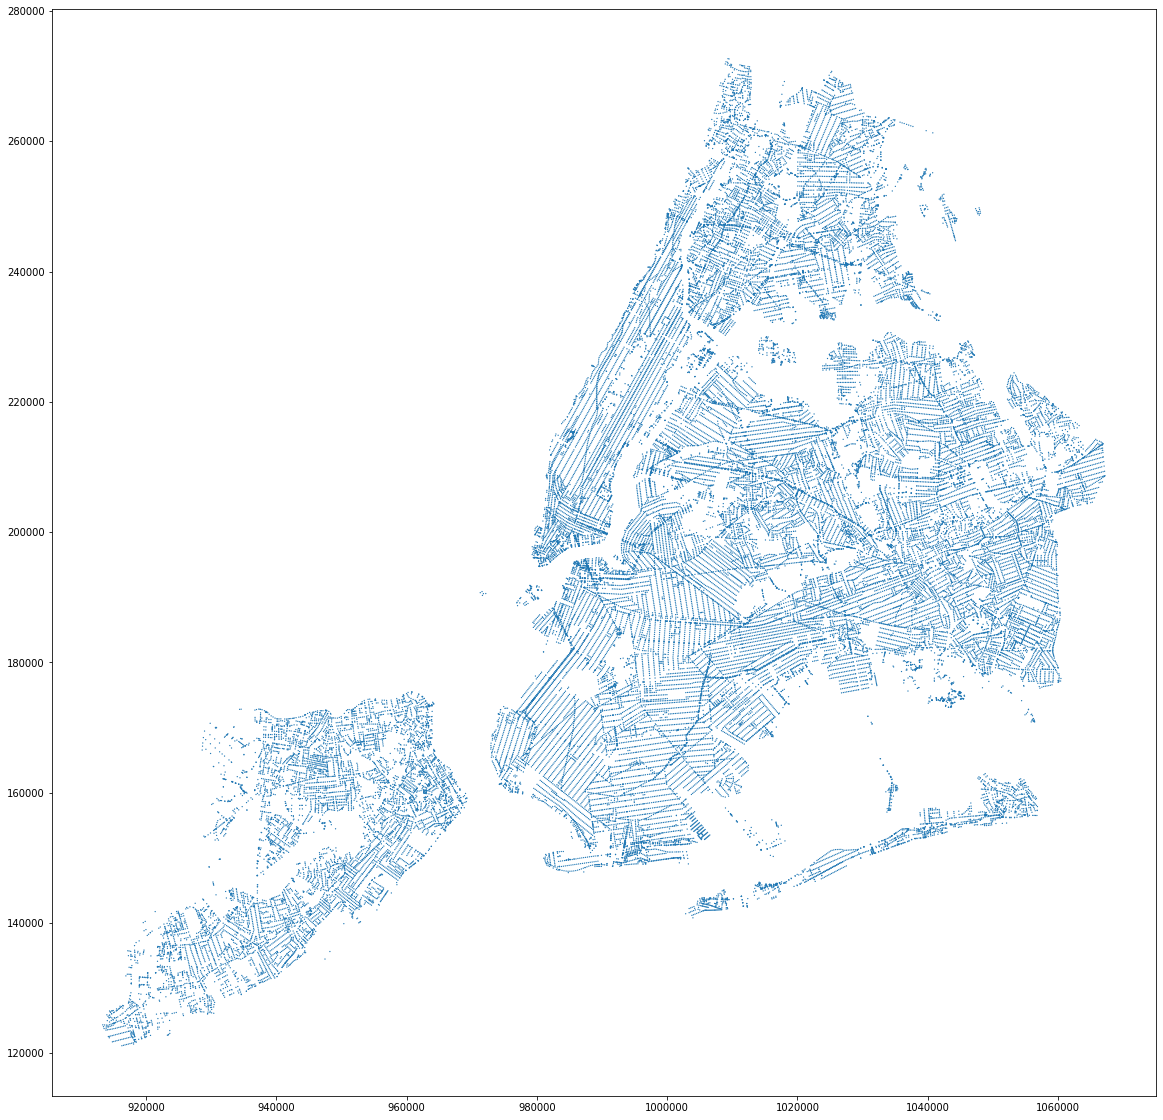

In [71]:
gd_buff1 = gd_buff.to_crs(epsg=2263) # convert to local projection
plt.rcParams['figure.figsize'] = [25, 20]
gd_buff1.plot()

Output of the buffer query is below. A few intersections in the south of Staten Island zoomed in with basemap from PostGIS

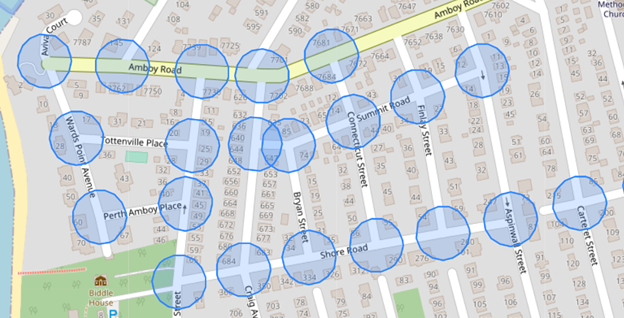

We now have the 30ft buffer, but the next step calls for finding the intersecting buffers, dissolving the intersected buffers, then merging them back into the same data. This can be done with one PostGIS query

In [ ]:
# Dissolving intersecting polygons with a nested query
pd.read_sql_query('''
                CREATE TABLE public.dissolve_intrsct AS 
                ( WITH dissolved AS
                (
                  SELECT ST_Union(pt.geom) as geom
                  FROM public.intrsct_buff as pt
                )  
                  SELECT (ST_DUMP(geom)).geom::geometry(POLYGON, 2263) as geom
                  FROM dissolved);
                                ''', conx)
# here I am making a union of all buffers that intersect, then using ST_DUMP to dissolve
# the polygons into local 2263 projection.



With dissolved polygons, there are many polygons that have multiple intersecting intersections in one area. When looking further down the line of the project, the total traffic counts and collision counts will naturally be higher than a single intersection, which will result in a higher weight..
If I use these dissolved polygons, a count field will need to be created to determine how many intersection polygons had been dissolved, but this would complicate when it comes to the issue of standardizing variables. 

Another approach: Using the intersection points, and finding the nearest collision points to each intersection. To do this, only points within buffer zones will be included. From there, collision data points and traffic counts can be standardized, then spatially joined with the standardized columns to intersection points, where the MCE calculation can be done.

In [ ]:
# postgis to find only points within dissolve_intrsct 30 foot buffer
valid_colls = pd.read_sql_query('''
                        CREATE TABLE valid_collisions AS(
                        SELECT cl.*
                        FROM public.collisions_prj as cl, public.dissolve_intrsct as ds
                        WHERE ST_WITHIN(cl.geom, ds.geom)
                        );
                        ''', conx)


Now using the valid collisions table, performing a distance (`<->`) function using a `CROSS LATERAL JOIN`. This query will return aggregated variables that will be used for our MCE analysis. All intersections that have the closest collisions points will be in the output (k-nearest neighbors). 

Credit to Paul Ramsey of CARTO for the `CROSS LATERAL JOIN` example https://carto.com/blog/lateral-joins/

In [ ]:
pd.read_sql_query('''
         CREATE TABLE intrsct_colls as(
 SELECT
    intersections.id as pid,
    sum(vc.number_of_persons_injured) as people_inj,
    sum(vc.number_of_persons_killed) as people_kill,
    sum(vc.number_of_pedestrians_injured) as ped_inj,
    sum(vc.number_of_pedestrians_killed) as ped_kill,
    sum(vc.number_of_motorist_injured) as motor_inj,
    sum(vc.number_of_motorist_killed) as motor_kill,
    count(vc.ped_location)::integer as ped_loc, -- cast string to integer
    sum(vc.count_col) as tot_indiv_count,
    count(*) as incident_ct,
    intersections.geom
FROM
 (SELECT * FROM
    public.valid_collisions
 ) as vc
CROSS JOIN LATERAL
   (SELECT pt.id, pt.geom
    FROM public.intrsct_pts as pt
    ORDER BY
        vc.geom <-> pt.geom
    LIMIT 1
   ) as intersections
GROUP BY pid, intersections.geom
ORDER BY incident_ct DESC);''', conx)

Our collisions and persons accident data has been aggregated and refined to only each individual intersection and its respective accident data. The next part is standardizing our variables and plotting this data in python.

View part 3 of the project: 'MCE Setup'